# Detecção de Facas com YOLOv11

## Introdução

Este notebook implementa um sistema completo de detecção de objetos utilizando o YOLOv11, focado especificamente na identificação de facas em imagens e vídeos de vigilância. O sistema pode ser utilizado em ambientes de segurança para detecção automática de armas brancas.

O modelo foi treinado utilizando um dataset cuidadosamente preparado na pasta `./dataset` que contém as divisões padronizadas:
- `train`: Conjunto de imagens e anotações para treinamento
- `valid`: Conjunto para validação durante o treinamento
- `test`: Conjunto independente para avaliação final

### Aplicações práticas:
- Sistemas de vigilância em tempo real
- Controle de segurança em ambientes públicos
- Detecção automática de armas brancas em vídeos

In [1]:
import json
import os
import random
import torch
import shutil
import logging
import subprocess
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from pathlib import Path
from PIL import Image
from typing import Tuple, List, Dict, Any

# Importações específicas para YOLOv11 usando a biblioteca ultralytics
from ultralytics import YOLO

current_directory = os.getcwd()

## Configuração de Logging

Configuramos o sistema de logging para monitorar o processo de treinamento e detecção. O nível INFO permite acompanhar as principais etapas do treinamento, incluindo carregamento de dados, início/fim do treinamento e avisos importantes sobre o processamento de imagens e vídeos.

In [2]:
# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

## Inspeção do Dataset

Vamos explorar a estrutura do dataset existente e verificar sua integridade.

In [3]:
def explore_dataset(base_path: Path) -> Dict[str, int]:
    """Explora a estrutura do dataset e retorna estatísticas."""
    stats = {}

    # Verifica existência dos diretórios principais
    for split in ['train', 'valid', 'test']:
        split_dir = base_path / split
        if not split_dir.exists():
            logging.warning(f"Diretório {split_dir} não encontrado!")
            continue

        images_dir = split_dir / 'images'
        labels_dir = split_dir / 'labels'

        if images_dir.exists():
            image_files = list(images_dir.glob('*.*'))
            stats[f'{split}_images'] = len(image_files)
        else:
            logging.warning(f"Diretório de imagens não encontrado em {split}!")
            stats[f'{split}_images'] = 0

        if labels_dir.exists():
            label_files = list(labels_dir.glob('*.txt'))
            stats[f'{split}_labels'] = len(label_files)
        else:
            logging.warning(f"Diretório de labels não encontrado em {split}!")
            stats[f'{split}_labels'] = 0

    return stats

In [4]:
# Caminho para o dataset
dataset_path = Path(f'{current_directory}/dataset')

# Explorar o dataset
dataset_stats = explore_dataset(dataset_path)
print("Estatísticas do dataset:")
for key, value in dataset_stats.items():
    print(f"{key}: {value}")

# Verificar o arquivo data.yaml
data_yaml_path = dataset_path / 'data.yaml'
if data_yaml_path.exists():
    print(f"\nArquivo data.yaml encontrado em: {data_yaml_path}")
    with open(data_yaml_path, 'r') as f:
        print(f.read())
else:
    logging.error(f"Arquivo data.yaml não encontrado em: {data_yaml_path}")

Estatísticas do dataset:
train_images: 2893
train_labels: 2893
valid_images: 797
valid_labels: 797
test_images: 385
test_labels: 385

Arquivo data.yaml encontrado em: c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\data.yaml
train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['knife']

roboflow:
  workspace: workspace-zqssx
  project: knife-dataset-new
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/workspace-zqssx/knife-dataset-new/dataset/1


## Visualização de Amostra do Dataset

Visualizar algumas imagens com suas respectivas anotações para confirmar que estão corretas.

In [5]:
def show_random_image_with_annotation(images_dir: Path, labels_dir: Path, n_samples: int = 3) -> None:
    """Exibe n_samples imagens aleatórias com suas respectivas anotações no formato YOLO."""
    if not images_dir.exists() or not labels_dir.exists():
        logging.error(f"Diretórios não existem: {images_dir} ou {labels_dir}")
        return
    
    image_files = list(images_dir.glob('*.*'))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    if not image_files:
        logging.warning(f"Nenhuma imagem encontrada em {images_dir}")
        return
    
    # Seleciona n_samples imagens aleatórias
    selected_images = random.sample(image_files, min(n_samples, len(image_files)))
    
    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
    if len(selected_images) == 1:
        axes = [axes]  # Força axes a ser uma lista para processamento uniforme
    
    for i, image_path in enumerate(selected_images):
        # Carrega a imagem
        img = Image.open(image_path)
        img_width, img_height = img.size
        
        # Procura o arquivo de label correspondente
        label_path = labels_dir / f"{image_path.stem}.txt"
        
        axes[i].imshow(img)
        axes[i].set_title(f"{image_path.name}")
        
        # Se existir o arquivo de label, desenha as bounding boxes
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:  # Formato YOLO: class x_center y_center width height
                        cls_id = int(parts[0])
                        x_center = float(parts[1]) * img_width
                        y_center = float(parts[2]) * img_height
                        width = float(parts[3]) * img_width
                        height = float(parts[4]) * img_height
                        
                        # Converte de coordenadas centrais para coordenadas de canto (x1, y1)
                        x1 = x_center - width / 2
                        y1 = y_center - height / 2
                        
                        # Desenha o retângulo
                        rect = patches.Rectangle(
                            (x1, y1), width, height,
                            linewidth=2, edgecolor='r', facecolor='none'
                        )
                        axes[i].add_patch(rect)
                        axes[i].annotate(f"knife", (x1, y1), color='white', backgroundcolor='red', fontsize=8)
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

Amostras do conjunto de treinamento:


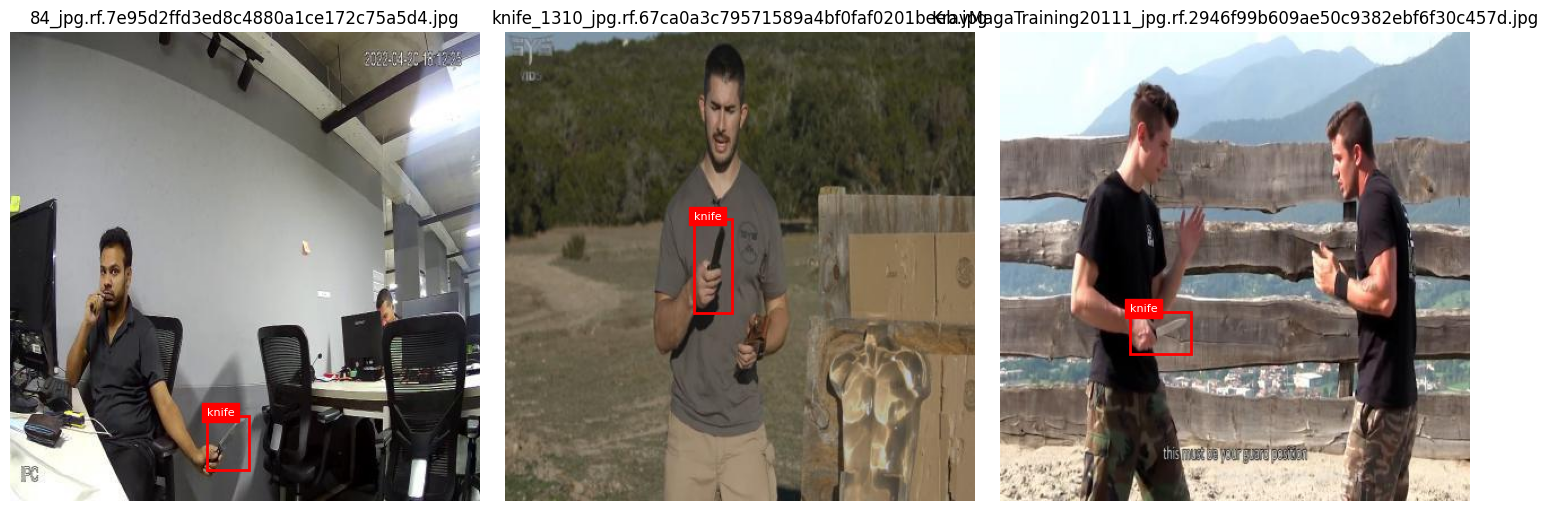

In [6]:
# Visualizar algumas imagens do conjunto de treino
train_images_dir = dataset_path / 'train' / 'images'
train_labels_dir = dataset_path / 'train' / 'labels'

print("Amostras do conjunto de treinamento:")
show_random_image_with_annotation(train_images_dir, train_labels_dir, n_samples=3)

## Treinamento do Modelo YOLOv11

Vamos treinar o modelo YOLOv11 utilizando o dataset existente.

In [7]:
def train_yolov11(data_yaml: Path, epochs: int = 50, img_size: int = 640, batch_size: int = 16, 
                  project: str = 'runs/train', name: str = 'exp', patience: int = 15) -> Path:
    """Treina o modelo YOLOv11 utilizando o dataset especificado."""
    
    # Verificamos se o arquivo data.yaml existe
    if not data_yaml.exists():
        raise FileNotFoundError(f"Arquivo data.yaml não encontrado: {data_yaml}")
    
    _device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Usando dispositivo: {_device}")
    # Inicializa o modelo YOLOv11 a partir do modelo pré-treinado
    model = YOLO('yolo11n.pt')  # Use 'yolov11n.pt' para um modelo menor e mais rápido
    model.to(_device)
    
    # Define os parâmetros de treinamento
    training_args = {
        'data': str(data_yaml),
        'epochs': epochs,
        'imgsz': img_size,
        'batch': batch_size,
        'project': project,
        'name': name,
        'patience': patience,  # Early stopping patience
        'verbose': True
    }
    
    # Executa o treinamento
    logging.info(f"Iniciando treinamento do YOLOv11 com {epochs} épocas, tamanho de imagem {img_size}")
    results = model.train(**training_args)
    
    # Retorna o caminho para o diretório de resultados do treinamento
    return Path(f"{project}/{name}")

In [8]:
# Defina os parâmetros de treinamento
data_yaml_path = Path(f'{current_directory}\dataset\data.yaml')
epochs = 120  # Reduza para testar mais rapidamente se necessário
img_size = 1024  # Tamanho padrão para YOLOv11
batch_size = 16  # Ajuste conforme capacidade da GPU

# Execute o treinamento
try:
    train_results_dir = train_yolov11(
        data_yaml=data_yaml_path, 
        epochs=epochs,
        img_size=img_size,
        batch_size=batch_size,
        project='runs/train',
        name='yolov11_knife_detection'
    )
    print(f"Treinamento concluído! Resultados salvos em: {train_results_dir}")
except Exception as e:
    logging.error(f"Erro durante o treinamento: {e}")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_18832\1267484829.py:2: SyntaxWarning: invalid escape sequence '\d'
  data_yaml_path = Path(f'{current_directory}\dataset\data.yaml')
INFO: Iniciando treinamento do YOLOv11 com 120 épocas, tamanho de imagem 1024


Usando dispositivo: cuda
New https://pypi.org/project/ultralytics/8.3.111 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\data.yaml, epochs=120, time=None, patience=15, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=runs/train, name=yolov11_knife_detection3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

train: Scanning C:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\train\labels.cache... 2893 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2893/2893 [00:00<?, ?it/s]
val: Scanning C:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\valid\labels.cache... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<?, ?it/s]


Plotting labels to runs\train\yolov11_knife_detection3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs\train\yolov11_knife_detection3
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120       5.3G      1.953      4.443      2.048         24       1024: 100%|██████████| 181/181 [00:47<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.15it/s]

                   all        797        849      0.198      0.122     0.0716     0.0226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      5.34G      2.091      3.145      2.195         20       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.65it/s]

                   all        797        849     0.0947      0.114     0.0405     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      5.34G      2.139      2.717      2.256         28       1024: 100%|██████████| 181/181 [00:43<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.89it/s]

                   all        797        849      0.268      0.261       0.19      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      5.34G      2.067      2.496      2.161         20       1024: 100%|██████████| 181/181 [00:42<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.04it/s]

                   all        797        849      0.407      0.338      0.295      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      5.34G      1.977       2.38      2.093         25       1024: 100%|██████████| 181/181 [00:42<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]

                   all        797        849      0.479      0.375      0.363      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      5.35G      1.905      2.213      2.018         27       1024: 100%|██████████| 181/181 [00:42<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]

                   all        797        849       0.37      0.277      0.235     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      5.34G      1.853      2.109      1.978         19       1024: 100%|██████████| 181/181 [00:42<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]

                   all        797        849      0.486      0.373      0.402      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      5.34G      1.868      2.011      1.952         21       1024: 100%|██████████| 181/181 [00:42<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.69it/s]

                   all        797        849      0.565      0.523      0.524      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      5.34G       1.81      1.947      1.918         18       1024: 100%|██████████| 181/181 [00:42<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]

                   all        797        849      0.654      0.458       0.51      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      5.34G      1.789      1.892      1.897         25       1024: 100%|██████████| 181/181 [00:42<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]

                   all        797        849      0.602      0.554      0.577      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      5.34G      1.783      1.847      1.889         19       1024: 100%|██████████| 181/181 [00:42<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        797        849      0.608      0.581      0.595      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      5.34G      1.747      1.749      1.842         24       1024: 100%|██████████| 181/181 [00:42<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        797        849      0.643      0.587      0.626      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      5.34G      1.737      1.723      1.835         18       1024: 100%|██████████| 181/181 [00:42<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

                   all        797        849      0.661      0.562      0.616      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      5.34G      1.716      1.703      1.822         28       1024: 100%|██████████| 181/181 [00:42<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        797        849      0.651      0.542      0.609      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      5.34G       1.68      1.616      1.775         23       1024: 100%|██████████| 181/181 [00:42<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]

                   all        797        849      0.739      0.578      0.679      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      5.34G      1.692      1.633      1.809         24       1024: 100%|██████████| 181/181 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.09it/s]

                   all        797        849      0.734      0.614      0.721      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      5.34G      1.663      1.558      1.758         23       1024: 100%|██████████| 181/181 [00:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.96it/s]

                   all        797        849      0.779      0.608      0.719      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      5.34G      1.648      1.533      1.758         19       1024: 100%|██████████| 181/181 [00:43<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]

                   all        797        849      0.805       0.66      0.754      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      5.34G      1.645      1.508      1.747         21       1024: 100%|██████████| 181/181 [00:42<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.92it/s]

                   all        797        849      0.795      0.602      0.716      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      5.34G      1.609      1.472      1.721         22       1024: 100%|██████████| 181/181 [00:42<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        797        849      0.794      0.683      0.765      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      5.34G        1.6      1.411      1.726         25       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.66it/s]

                   all        797        849       0.81       0.65       0.76      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      5.34G      1.574      1.375      1.692         19       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.92it/s]

                   all        797        849      0.807      0.736      0.801      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      5.34G      1.595      1.388      1.715         27       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]

                   all        797        849      0.832      0.729      0.824      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      5.34G      1.573      1.379      1.699         16       1024: 100%|██████████| 181/181 [00:43<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]

                   all        797        849      0.767      0.674      0.751      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      5.34G      1.574      1.355      1.696         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all        797        849      0.803      0.724      0.812      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120      5.34G      1.553      1.327      1.667         24       1024: 100%|██████████| 181/181 [00:49<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.47it/s]

                   all        797        849      0.843      0.722      0.809      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      5.34G      1.557      1.302      1.667         20       1024: 100%|██████████| 181/181 [00:44<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.63it/s]

                   all        797        849      0.851      0.752      0.835      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      5.34G      1.543      1.313      1.677         26       1024: 100%|██████████| 181/181 [00:43<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

                   all        797        849      0.823      0.733       0.81      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      5.34G      1.538        1.3      1.653         21       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]

                   all        797        849      0.848      0.704      0.806      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      5.34G       1.49      1.245      1.611         17       1024: 100%|██████████| 181/181 [00:47<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]

                   all        797        849      0.849      0.736      0.833      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      5.34G      1.525      1.254      1.645         28       1024: 100%|██████████| 181/181 [00:46<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.70it/s]

                   all        797        849      0.855      0.757      0.842      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      5.34G      1.484      1.259       1.63         22       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]

                   all        797        849      0.836      0.756      0.836      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      5.34G      1.519      1.271      1.632         19       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.77it/s]

                   all        797        849      0.868      0.773      0.858      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      5.34G      1.488      1.233      1.619         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.65it/s]

                   all        797        849       0.88       0.75      0.845       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      5.34G      1.496      1.197      1.617         24       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.59it/s]

                   all        797        849      0.853       0.76      0.853      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      5.34G      1.489      1.199       1.62         22       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]

                   all        797        849      0.904      0.758      0.852      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120      5.34G      1.478      1.199      1.615         20       1024: 100%|██████████| 181/181 [00:45<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]

                   all        797        849      0.879      0.777      0.849      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      5.34G      1.451      1.152      1.575         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.56it/s]

                   all        797        849      0.867      0.763      0.847      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      5.34G      1.457      1.143       1.58         23       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.50it/s]

                   all        797        849      0.848      0.781      0.854      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      5.34G      1.443      1.128      1.574         33       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]

                   all        797        849      0.898      0.744      0.859      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      5.34G      1.432      1.102      1.567         22       1024: 100%|██████████| 181/181 [00:44<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.47it/s]

                   all        797        849      0.868      0.756      0.862      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      5.34G       1.43       1.11      1.568         22       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.44it/s]

                   all        797        849      0.883      0.793      0.872      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      5.34G      1.404      1.089      1.542         26       1024: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]

                   all        797        849      0.859      0.797      0.866      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      5.34G       1.42      1.092      1.561         31       1024: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.98it/s]

                   all        797        849      0.873      0.792      0.872      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      5.34G       1.42      1.102       1.56         20       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]

                   all        797        849      0.855      0.806      0.877      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      5.34G      1.414      1.077      1.552         27       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]

                   all        797        849      0.876       0.79      0.868      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      5.34G      1.419      1.074      1.564         23       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.13it/s]

                   all        797        849      0.875      0.803      0.879      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120      5.34G      1.385      1.026      1.524         21       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.00it/s]

                   all        797        849      0.866       0.77       0.85      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      5.34G      1.393      1.044      1.552         18       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.57it/s]

                   all        797        849      0.868      0.818      0.878      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      5.34G      1.368      1.028      1.511         27       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]

                   all        797        849      0.887      0.812      0.887      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120      5.34G      1.371      1.026      1.539         25       1024: 100%|██████████| 181/181 [00:43<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.49it/s]

                   all        797        849      0.863      0.822      0.901      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120      5.34G      1.384      1.031       1.53         26       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]

                   all        797        849      0.883      0.798      0.888      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      5.34G      1.354     0.9934      1.496         22       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]

                   all        797        849      0.893      0.826      0.893      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      5.34G      1.348     0.9881      1.495         21       1024: 100%|██████████| 181/181 [00:43<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.55it/s]

                   all        797        849      0.877      0.816      0.896      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      5.34G      1.329      0.997      1.486         24       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.55it/s]

                   all        797        849      0.899      0.788      0.874       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      5.34G      1.345     0.9851      1.498         21       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]

                   all        797        849      0.879      0.822      0.897      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      5.34G      1.334     0.9714      1.489         27       1024: 100%|██████████| 181/181 [00:43<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.60it/s]

                   all        797        849      0.877       0.82      0.896      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      5.34G      1.336      0.984      1.497         19       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]

                   all        797        849      0.889       0.81       0.89      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      5.34G      1.332     0.9824       1.49         26       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]

                   all        797        849      0.911      0.811      0.889      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      5.34G       1.32     0.9568      1.475         25       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]

                   all        797        849       0.92      0.795      0.899      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      5.38G      1.301     0.9422      1.466         18       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]

                   all        797        849       0.91      0.835      0.899      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      5.34G        1.3     0.9334      1.455         16       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]

                   all        797        849      0.896       0.84      0.899      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      5.34G      1.292     0.9197      1.461         20       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.87it/s]

                   all        797        849      0.893      0.843      0.907      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/120      5.34G      1.296     0.9154      1.456         22       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]

                   all        797        849       0.92      0.829       0.91      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/120      5.34G      1.287     0.9212      1.454         17       1024: 100%|██████████| 181/181 [00:43<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]

                   all        797        849      0.893       0.85      0.904      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/120      5.34G      1.285     0.9147      1.458         21       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]

                   all        797        849        0.9      0.829      0.899      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/120      5.34G       1.28     0.9118      1.445         23       1024: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.21it/s]

                   all        797        849      0.889      0.867      0.907       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/120      5.34G      1.262     0.8956      1.436         18       1024: 100%|██████████| 181/181 [00:45<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]

                   all        797        849      0.904      0.841      0.911       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/120      5.34G      1.286     0.9141      1.467         26       1024: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]

                   all        797        849      0.929      0.842      0.916      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/120      5.34G      1.262     0.8819      1.419         23       1024: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.57it/s]

                   all        797        849      0.896      0.846      0.895      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/120      5.34G      1.267     0.8837      1.432         31       1024: 100%|██████████| 181/181 [00:45<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.59it/s]

                   all        797        849      0.914      0.827        0.9      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/120      5.34G      1.255     0.8876      1.432         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]

                   all        797        849      0.924      0.837      0.917      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/120      5.34G      1.241     0.8794      1.421         21       1024: 100%|██████████| 181/181 [00:44<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.36it/s]

                   all        797        849      0.909       0.84      0.917      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/120      5.34G      1.239     0.8584      1.403         17       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]

                   all        797        849      0.926      0.855      0.914      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/120      5.37G      1.236     0.8532      1.417         14       1024: 100%|██████████| 181/181 [00:45<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all        797        849      0.916      0.859      0.916       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/120      5.34G      1.227     0.8448      1.419         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.08it/s]

                   all        797        849      0.929      0.859      0.911      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/120      5.34G      1.221     0.8347      1.403         26       1024: 100%|██████████| 181/181 [00:45<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]

                   all        797        849      0.915      0.862      0.919       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/120      5.34G      1.217     0.8379       1.39         24       1024: 100%|██████████| 181/181 [00:43<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all        797        849      0.937      0.855      0.918      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/120      5.34G      1.234     0.8557      1.418         27       1024: 100%|██████████| 181/181 [00:43<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]

                   all        797        849      0.931      0.856      0.921      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/120      5.34G       1.21     0.8239      1.403         20       1024: 100%|██████████| 181/181 [00:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]

                   all        797        849      0.922      0.857      0.918      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/120      5.34G      1.202      0.823      1.398         20       1024: 100%|██████████| 181/181 [00:45<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.13it/s]

                   all        797        849      0.937      0.863      0.923      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/120      5.34G      1.213     0.8335      1.404         29       1024: 100%|██████████| 181/181 [00:43<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]

                   all        797        849      0.949      0.855      0.927      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/120      5.38G      1.199     0.8121      1.385         16       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.06it/s]

                   all        797        849      0.946       0.86      0.931      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/120      5.34G      1.194     0.8051      1.382         28       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]

                   all        797        849      0.938      0.878      0.925      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/120      5.34G      1.181      0.792      1.367         22       1024: 100%|██████████| 181/181 [00:44<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.88it/s]

                   all        797        849      0.934      0.873      0.925       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/120      5.34G      1.189     0.7932       1.37         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.12it/s]

                   all        797        849      0.943      0.859      0.921      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/120      5.34G       1.17     0.7864      1.363         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]

                   all        797        849      0.928      0.861       0.92      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/120      5.34G      1.168     0.7825      1.375         24       1024: 100%|██████████| 181/181 [00:45<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]

                   all        797        849      0.932      0.856      0.921      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/120      5.34G      1.177     0.7822      1.375         23       1024: 100%|██████████| 181/181 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]

                   all        797        849      0.932      0.866      0.926      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/120      5.34G       1.17     0.7705      1.354         20       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]

                   all        797        849      0.928      0.865      0.923      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/120      5.34G      1.158     0.7743      1.365         28       1024: 100%|██████████| 181/181 [00:44<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.50it/s]

                   all        797        849      0.945      0.868      0.925      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/120      5.34G      1.155     0.7638      1.363         19       1024: 100%|██████████| 181/181 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all        797        849      0.922      0.873      0.923      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/120      5.34G      1.145      0.767      1.342         26       1024: 100%|██████████| 181/181 [00:44<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]

                   all        797        849      0.927      0.867      0.922      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/120      5.34G      1.144     0.7758      1.353         15       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.41it/s]

                   all        797        849      0.933      0.873      0.926      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/120      5.34G      1.138     0.7613      1.346         26       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.42it/s]

                   all        797        849      0.917      0.883      0.927      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/120      5.34G      1.134     0.7599      1.341         27       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.11it/s]

                   all        797        849       0.93      0.874      0.931      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/120      5.34G      1.141     0.7579      1.353         24       1024: 100%|██████████| 181/181 [00:44<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]

                   all        797        849      0.918      0.885      0.926      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/120      5.34G      1.124       0.74      1.332         19       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.48it/s]

                   all        797        849      0.932      0.869      0.924      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/120      5.34G      1.112     0.7321      1.331         16       1024: 100%|██████████| 181/181 [00:44<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.44it/s]

                   all        797        849      0.931      0.871      0.924      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/120      5.34G      1.113     0.7314      1.329         21       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.25it/s]

                   all        797        849      0.928      0.885      0.925      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/120      5.34G      1.104     0.7042      1.317         29       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.38it/s]

                   all        797        849      0.934      0.867      0.927      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/120      5.34G      1.104     0.7265      1.322         28       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.80it/s]

                   all        797        849      0.948      0.874      0.941      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/120      5.34G      1.096      0.704      1.311         22       1024: 100%|██████████| 181/181 [00:44<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.83it/s]

                   all        797        849      0.929      0.881      0.936      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/120      5.34G      1.121     0.7386      1.339         26       1024: 100%|██████████| 181/181 [00:44<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]

                   all        797        849      0.935      0.882      0.932      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/120      5.34G      1.066      0.689      1.299         14       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]

                   all        797        849      0.934      0.881       0.93      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/120      5.34G      1.079     0.7004      1.296         17       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.82it/s]

                   all        797        849      0.925      0.887      0.931      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/120      5.34G       1.08     0.6955      1.307         23       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.86it/s]

                   all        797        849      0.937      0.875      0.932      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/120      5.34G      1.089     0.7006      1.301         20       1024: 100%|██████████| 181/181 [00:45<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.88it/s]

                   all        797        849      0.929      0.894      0.937      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/120      5.34G      1.058      0.686      1.291         19       1024: 100%|██████████| 181/181 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]

                   all        797        849      0.926      0.889      0.938      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/120      5.34G      1.056     0.6841      1.287         23       1024: 100%|██████████| 181/181 [00:45<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]

                   all        797        849      0.931      0.872      0.931      0.572


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/120      5.59G      1.023     0.5221      1.284         14       1024: 100%|██████████| 181/181 [00:44<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.90it/s]

                   all        797        849      0.939      0.879      0.934      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/120      5.34G      1.013     0.5205       1.29         14       1024: 100%|██████████| 181/181 [00:44<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.84it/s]

                   all        797        849      0.924      0.877      0.929      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/120      5.34G      1.008     0.5034      1.287         13       1024: 100%|██████████| 181/181 [00:44<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.20it/s]

                   all        797        849      0.947      0.876      0.932      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/120      5.34G     0.9901     0.4985      1.271         13       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.48it/s]

                   all        797        849      0.946      0.872      0.931      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/120      5.34G     0.9717     0.4892      1.264         13       1024: 100%|██████████| 181/181 [00:44<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:08<00:00,  3.07it/s]

                   all        797        849      0.933      0.883      0.929      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/120      5.34G     0.9801     0.4846      1.255         13       1024: 100%|██████████| 181/181 [00:43<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.61it/s]

                   all        797        849      0.938      0.878       0.93      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/120      5.34G     0.9555     0.4802      1.248         13       1024: 100%|██████████| 181/181 [00:44<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]

                   all        797        849      0.941      0.884       0.93      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/120      5.34G     0.9608     0.4751      1.246         14       1024: 100%|██████████| 181/181 [00:43<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.47it/s]

                   all        797        849      0.933       0.88      0.929      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/120      5.34G     0.9614     0.4783      1.251         14       1024: 100%|██████████| 181/181 [00:44<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.49it/s]

                   all        797        849      0.924      0.889      0.931      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/120      5.34G     0.9578     0.4832      1.244         14       1024: 100%|██████████| 181/181 [00:43<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.50it/s]

                   all        797        849      0.939      0.875       0.93      0.575



120 epochs completed in 1.744 hours.
Optimizer stripped from runs\train\yolov11_knife_detection3\weights\last.pt, 5.6MB
Optimizer stripped from runs\train\yolov11_knife_detection3\weights\best.pt, 5.6MB

Validating runs\train\yolov11_knife_detection3\weights\best.pt...
Ultralytics 8.3.109  Python-3.12.4 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:07<00:00,  3.54it/s]


                   all        797        849      0.932      0.881      0.929      0.576
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs\train\yolov11_knife_detection3
Treinamento concluído! Resultados salvos em: runs\train\yolov11_knife_detection


## Execução da Avaliação do Modelo

Após definir a função de avaliação, vamos aplicá-la ao nosso modelo treinado para obter as métricas de desempenho. O modelo utilizado para avaliação é a versão 'best.pt', que representa o checkpoint com melhor desempenho durante o treinamento.

Essas métricas nos permitirão quantificar objetivamente a eficácia do detector de facas em situações reais e compará-lo com versões futuras ou outros modelos.

In [9]:
def evaluate_model(model_path: Path, data_yaml: Path) -> Dict:
    """Avalia o desempenho do modelo YOLOv11 treinado."""
    
    # Carrega o modelo treinado
    model = YOLO(model_path)
    
    # Realiza a validação no conjunto de validação
    results = model.val(data=str(data_yaml))
    
    # Extrai métricas relevantes
    metrics = {
        'precision': results.box.maps[-1] if hasattr(results.box, 'maps') and len(results.box.maps) > 0 else 0,  # mAP@0.5
        'mAP50-95': results.box.map if hasattr(results.box, 'map') else 0,  # mAP@0.5:0.95
        'recall': results.box.mar if hasattr(results.box, 'mar') else 0  # Mean Average Recall
    }
    
    return metrics

In [ ]:
# Caminho para o melhor modelo treinado
best_model_path = Path(f'{current_directory}/runs/train/yolov11_knife_detection2/weights/best.pt')

# Se o modelo existir, avalie-o
if best_model_path.exists():
    metrics = evaluate_model(best_model_path, data_yaml_path)
    print("Métricas de avaliação:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
else:
    print(f"Modelo não encontrado em {best_model_path}")

Ultralytics 8.3.109  Python-3.12.4 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning C:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\valid\labels.cache... 797 images, 0 backgrounds, 0 corrupt: 100%|██████████| 797/797 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


                   all        797        849      0.933      0.879      0.928      0.576
Speed: 0.8ms preprocess, 5.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\val4
Métricas de avaliação:
precision: 0.5758
mAP50-95: 0.5758
recall: 0.0000


## Visualização dos Gráficos de Treinamento

Após avaliar o modelo com métricas numéricas, vamos visualizar os gráficos gerados durante o treinamento para uma análise mais profunda do seu desempenho. Estes gráficos oferecem insights valiosos sobre:

- **Matriz de Confusão**: Mostra a distribuição das predições corretas e incorretas, ajudando a identificar falsos positivos e falsos negativos
- **Resultados do Treinamento**: Evolução das métricas (perda, precisão, recall) ao longo das épocas de treinamento
- **Curva de Precision-Recall (PR)**: Relação entre precisão e recall em diferentes thresholds, essencial para determinar o threshold ideal
- **Curva F1**: Visualização do score F1 (média harmônica entre precisão e recall) em diferentes configurações

A análise destes gráficos é fundamental para entender o comportamento do modelo e identificar oportunidades de melhoria.

In [11]:
def display_training_plots(results_dir: Path) -> None:
    """Exibe os gráficos gerados durante o treinamento do modelo YOLOv11."""
    # Verifica se o diretório de resultados existe
    if not results_dir.exists():
        print(f"Diretório de resultados não encontrado: {results_dir}")
        return

    # Caminhos para as imagens de gráficos gerados pelo YOLOv11
    confusion_matrix_path = results_dir / 'confusion_matrix.png'
    results_plot_path = results_dir / 'results.png'
    pr_curve_path = results_dir / 'PR_curve.png'
    f1_curve_path = results_dir / 'F1_curve.png'
    
    # Configuração para exibição dos gráficos
    plt.figure(figsize=(15, 12))
    
    # Exibe os gráficos encontrados
    plot_count = 0
    plot_paths = [
        (confusion_matrix_path, "Matriz de Confusão"),
        (results_plot_path, "Resultados do Treinamento"),
        (pr_curve_path, "Curva de Precision-Recall"),
        (f1_curve_path, "Curva F1")
    ]
    
    # Filtra apenas os caminhos que existem
    valid_plots = [(path, title) for path, title in plot_paths if path.exists()]
    plot_count = len(valid_plots)
    
    if plot_count == 0:
        print("Nenhum gráfico encontrado nos resultados do treinamento.")
        return
    
    # Calcular linhas e colunas para subplots
    if plot_count <= 2:
        rows, cols = 1, plot_count
    else:
        rows = (plot_count + 1) // 2  # Arredonda para cima
        cols = 2
    
    # Exibe cada gráfico encontrado
    for i, (plot_path, title) in enumerate(valid_plots):
        plt.subplot(rows, cols, i + 1)
        img = plt.imread(plot_path)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Exibidos {plot_count} gráficos de avaliação do modelo.")

Exibindo gráficos de avaliação do modelo:


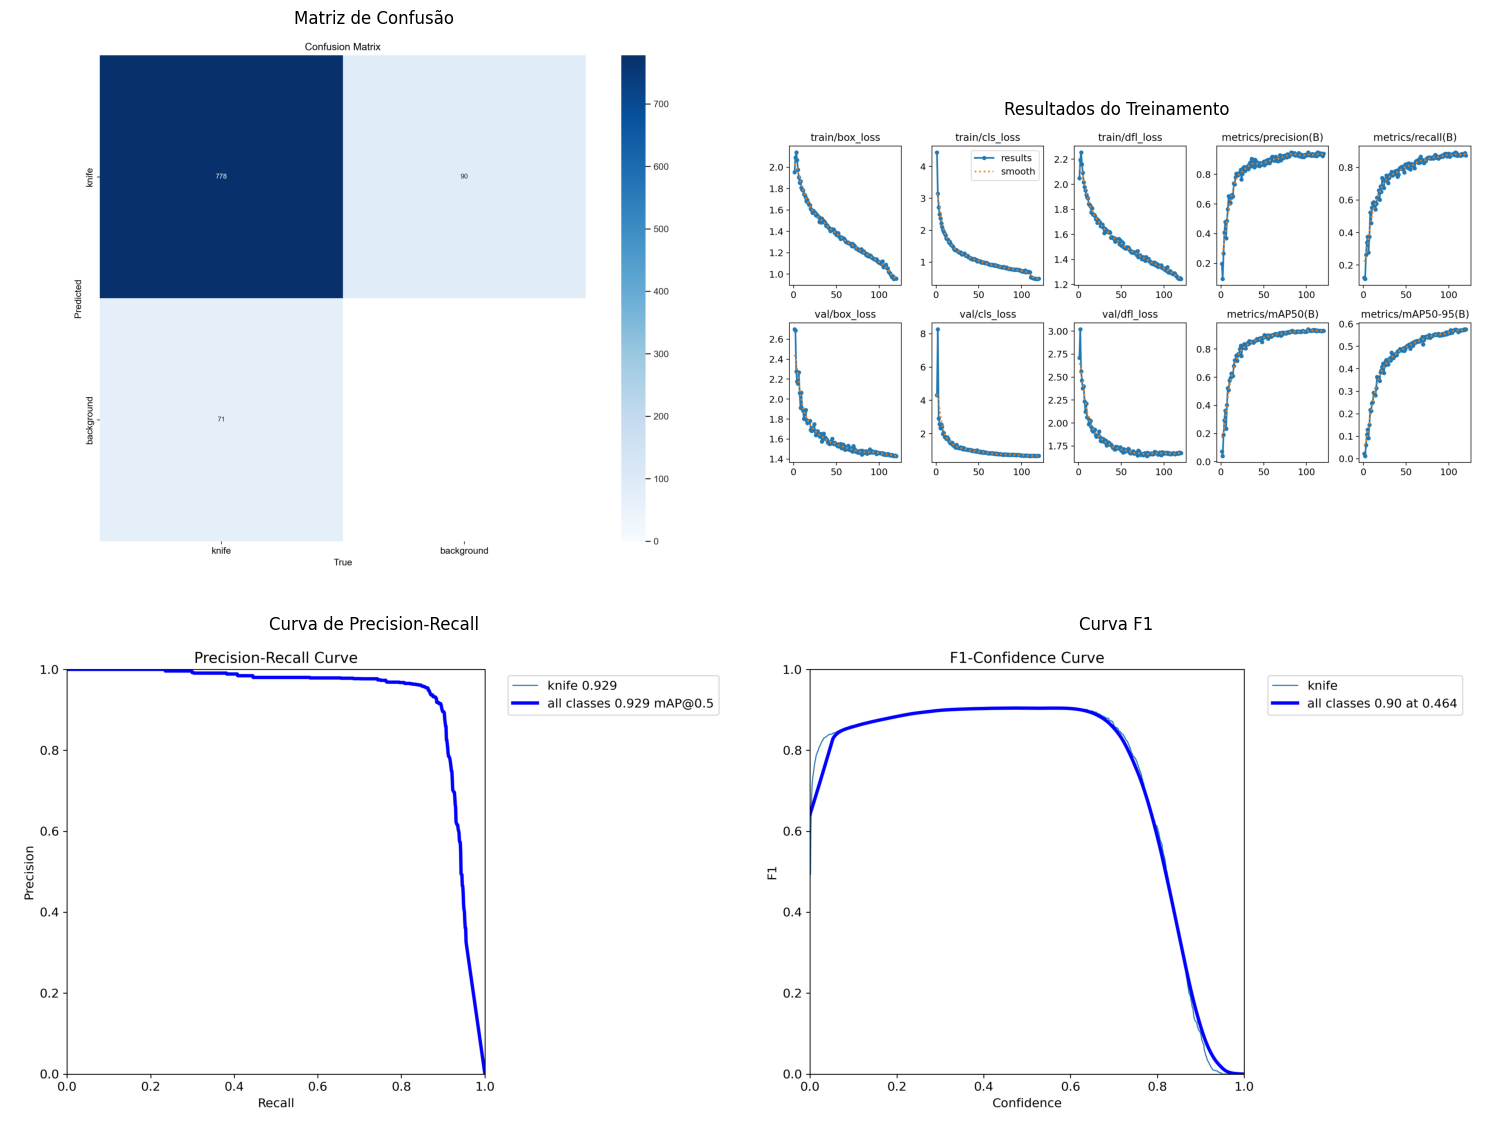

Exibidos 4 gráficos de avaliação do modelo.


In [ ]:
# Exibe os gráficos gerados durante o treinamento/avaliação
# O caminho deve apontar para a pasta que contém os resultados do treinamento
results_dir = Path(f'{current_directory}/runs/train/yolov11_knife_detection2')

if results_dir.exists():
    print("Exibindo gráficos de avaliação do modelo:")
    display_training_plots(results_dir)
else:
    print(f"Diretório de resultados não encontrado: {results_dir}")

## Teste em Imagens

Nesta seção, avaliaremos o desempenho do modelo em imagens reais do conjunto de teste. Este é um passo crucial para verificar se o modelo consegue detectar facas em cenários do mundo real e diferentes condições de iluminação, ângulos e distâncias.

Para cada imagem, o modelo irá:
1. Detectar a presença de facas
2. Desenhar caixas delimitadoras (bounding boxes) ao redor dos objetos detectados
3. Atribuir uma pontuação de confiança que indica a certeza da detecção

O threshold de confiança está definido em 0.25 (25%), o que significa que apenas detecções com confiança superior a este valor serão consideradas.

In [13]:
def test_on_images(model_path: Path, test_images_dir: Path, conf_threshold: float = 0.25, n_samples: int = 3) -> None:
    """Testa o modelo em algumas imagens do conjunto de teste e visualiza os resultados."""
    
    if not test_images_dir.exists():
        logging.error(f"Diretório de imagens de teste não encontrado: {test_images_dir}")
        return
        
    # Carrega o modelo
    model = YOLO(model_path)
    
    # Lista as imagens no diretório de teste
    image_files = list(test_images_dir.glob('*.*'))
    image_files = [f for f in image_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    if not image_files:
        logging.warning(f"Nenhuma imagem encontrada em {test_images_dir}")
        return
        
    # Seleciona n_samples imagens aleatórias
    selected_images = random.sample(image_files, min(n_samples, len(image_files)))
    
    # Processa cada imagem selecionada
    fig, axes = plt.subplots(1, len(selected_images), figsize=(5*len(selected_images), 5))
    if len(selected_images) == 1:
        axes = [axes]  # Força axes a ser uma lista para processamento uniforme
        
    for i, img_path in enumerate(selected_images):
        # Executa a detecção
        results = model(img_path, conf=conf_threshold)
        
        # Obtém a imagem com as detecções já plotadas
        res_plotted = results[0].plot()
        
        # Adiciona a imagem ao subplot
        axes[i].imshow(res_plotted)
        axes[i].set_title(f"{img_path.name}")
        axes[i].axis('off')
        
        # Exibe informações sobre as detecções
        detections = results[0].boxes
        print(f"Imagem: {img_path.name} - {len(detections)} detecções")
        
    plt.tight_layout()
    plt.show()


image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\test\images\DSC_0034_JPG_jpg.rf.84d5c93fa5d853ad31236d24a3c1ab12.jpg: 1024x1024 1 knife, 11.2ms
Speed: 10.1ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)
Imagem: DSC_0034_JPG_jpg.rf.84d5c93fa5d853ad31236d24a3c1ab12.jpg - 1 detecções

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\test\images\knife_109_jpg.rf.9bee30df7f9ecd0a420399ca7e01ea30.jpg: 1024x1024 1 knife, 9.7ms
Speed: 5.8ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)
Imagem: knife_109_jpg.rf.9bee30df7f9ecd0a420399ca7e01ea30.jpg - 1 detecções

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\test\images\132_jpg.rf.00d080b1e1e7519912346b64b00614a7.jpg: 1024x1024 1 knife, 13.4ms
Speed: 6.0ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)
Imagem: 132_jpg.rf.00d080b1e1e7519912346b64b0061

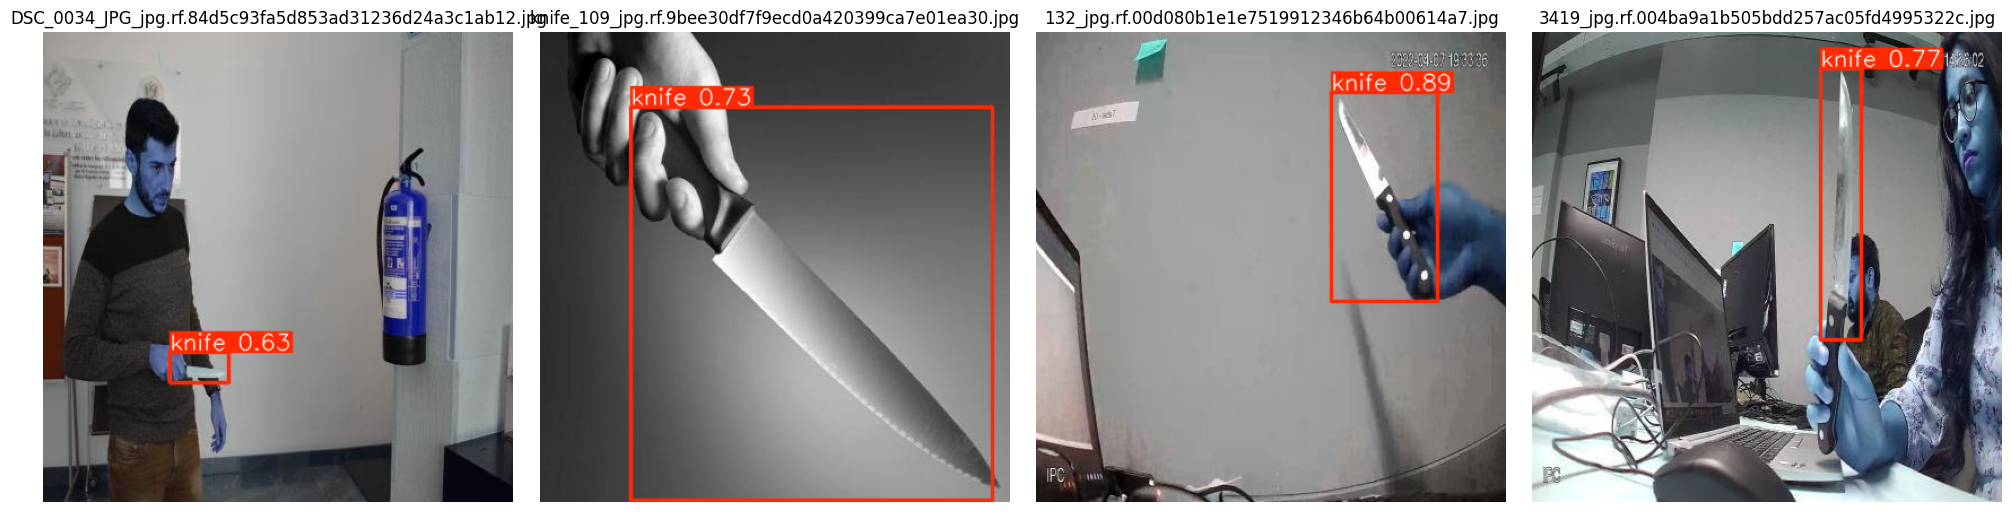

In [14]:
# Caminho para o diretório de imagens de teste
test_images_dir = Path(f'{current_directory}/dataset/test/images')

# Se o modelo existir, teste-o em algumas imagens
if best_model_path.exists():
    test_on_images(best_model_path, test_images_dir, conf_threshold=0.25, n_samples=4)
else:
    print(f"Modelo não encontrado em {best_model_path}")

## Teste em Vídeos

A detecção em vídeos é fundamental para aplicações de segurança em tempo real. Nesta seção, processamos vídeos frame a frame para identificar a presença de facas.

### Processo de análise de vídeo:
1. O modelo analisa cada frame do vídeo individualmente
2. Facas são detectadas e marcadas com bounding boxes
3. Um contador registra frames com detecções positivas
4. O vídeo processado é salvo com anotações visuais

Esta capacidade de processar vídeos permite implementar um sistema de vigilância automatizado que pode ser integrado a câmeras de segurança existentes.

In [15]:
def process_video(model_path: Path, video_path: Path, output_dir: Path, conf_threshold: float = 0.25) -> Path:
    """Processa um vídeo para detectar facas em cada frame."""
    
    if not video_path.exists():
        logging.error(f"Vídeo não encontrado: {video_path}")
        return None
        
    # Cria o diretório de saída se não existir
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Caminho para o vídeo de saída
    output_path = output_dir / f"{video_path.stem}_analyzed{video_path.suffix}"
    
    # Carrega o modelo
    model = YOLO(model_path)
    
    # Processa o vídeo
    logging.info(f"Processando vídeo: {video_path.name}")
    results = model.predict(
        source=str(video_path),
        conf=conf_threshold,
        save=True,
        project=str(output_dir.parent),
        name=output_dir.name,
        exist_ok=True
    )
    
    # Retorna o caminho para o vídeo processado (calculando onde o YOLO salva por padrão)
    processed_video = output_dir / f"{video_path.name}"
    if processed_video.exists():
        return processed_video
    return None

In [16]:
# Caminho para o diretório de vídeos
videos_dir = Path('./videos')
output_dir = Path('./output_videos')

# Lista os vídeos disponíveis
if videos_dir.exists():
    video_files = list(videos_dir.glob('*.mp4'))
    
    if video_files:
        # Se o modelo existir, processa os vídeos
        if best_model_path.exists():
            for video_path in video_files:
                processed_video = process_video(best_model_path, video_path, output_dir, conf_threshold=0.25)
                if processed_video:
                    print(f"Vídeo processado: {processed_video}")
        else:
            print(f"Modelo não encontrado em {best_model_path}")
    else:
        print(f"Nenhum vídeo encontrado em {videos_dir}")
else:
    print(f"Diretório de vídeos não encontrado: {videos_dir}")

INFO: Processando vídeo: video.mp4




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 50.5ms
video 1/1 (frame 2/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 9.7ms
video 1/1 (frame 3/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 12.4ms
video 1/1 (frame 4/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\kn

INFO: Processando vídeo: video2.mp4




WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 1 knife, 11.7ms
video 1/1 (frame 2/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 1 knife, 10.6ms
video 1/1 (frame 3/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 1 knife, 12.1ms
video 1/1 (frame 4/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\vid

## Sistema de Alerta

Esta seção implementa um sistema de notificação automática que pode ser integrado a um ambiente de segurança real. Quando o modelo detecta facas em vídeos ou imagens, resumos detalhados são gerados e enviados através de:

1. **Notificações por e-mail** - Utilizando webhooks para enviar relatórios detalhados
2. **Mensagens WhatsApp** - Para alertas imediatos aos responsáveis pela segurança
3. **Arquivos de relatório** - Salvos localmente para análise posterior

Este sistema de alertas permite uma resposta rápida a potenciais ameaças, fornecendo informações precisas sobre onde e quando facas foram detectadas.

In [17]:
def generate_video_detection_summary(model_path: Path, videos_dir: Path, conf_threshold: float = 0.25) -> str:
    """Gera um resumo detalhado das detecções nos vídeos."""
    
    if not model_path.exists():
        return "Modelo não encontrado."
        
    if not videos_dir.exists():
        return "Diretório de vídeos não encontrado."
    
    # Lista os vídeos disponíveis
    video_files = list(videos_dir.glob('*.mp4'))
    if not video_files:
        return "Nenhum vídeo encontrado."
    
    # Carrega o modelo
    model = YOLO(model_path)
    
    summary = ""
    
    # Analisa cada vídeo
    for video_idx, video_path in enumerate(video_files, 1):
        # Realiza as predições frame por frame sem salvar o vídeo
        results = model.predict(source=str(video_path), conf=conf_threshold, stream=True)
        
        total_frames = 0
        frames_with_knife = 0
        frames_without_knife = 0
        total_knives = 0
        
        # Analisa cada frame
        for frame_idx, result in enumerate(results):
            total_frames += 1
            detections = result.boxes
            
            if len(detections) > 0:
                frames_with_knife += 1
                total_knives += len(detections)
            else:
                frames_without_knife += 1
        
        # Adiciona o resumo deste vídeo
        video_summary = f"Video {video_idx}: {video_path.name}\n"
        video_summary += f"- Número de frames analisados: {total_frames}\n"
        video_summary += f"- Número de frames onde facas foram detectadas: {frames_with_knife}\n"
        video_summary += f"- Número de frames sem facas: {frames_without_knife}\n"
        video_summary += f"- Número total de facas detectadas: {total_knives}\n\n"
        
        summary += video_summary
        logging.info(f"Análise concluída para o vídeo {video_path.name}")
    
    return summary

In [18]:
def send_alert_via_webhook(summary: str, recipient_email: str, webhook_url: str) -> None:
    """Envia um alerta via webhook quando facas são detectadas."""
    
    payload = {
        "email": recipient_email,
        "summary": summary
    }
    
    try:
        response = requests.post(webhook_url, json=payload)
        if response.ok:
            logging.info("Alerta enviado com sucesso!")
        else:
            logging.error(f"Erro ao enviar alerta: {response.status_code} - {response.text}")
    except Exception as e:
        logging.error(f"Exceção ao enviar alerta: {e}")

In [19]:
def generate_detection_summary(model_path: Path, test_dir: Path, conf_threshold: float = 0.25) -> str:
    """Gera um resumo das detecções no diretório de teste."""
    
    if not test_dir.exists():
        return "Diretório de teste não encontrado."
    
    # Carrega o modelo
    model = YOLO(model_path)
    
    # Lista as imagens de teste
    test_images = list(test_dir.glob('*.*'))
    test_images = [img for img in test_images if img.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    
    if not test_images:
        return "Nenhuma imagem encontrada no diretório de teste."
        
    total_images = len(test_images)
    images_with_knife = 0
    total_knives = 0
    
    # Processa cada imagem
    for img_path in test_images:
        results = model(img_path, conf=conf_threshold)
        detections = results[0].boxes
        
        if len(detections) > 0:
            images_with_knife += 1
            total_knives += len(detections)
    
    # Gera o resumo
    summary = f"Das {total_images} imagens testadas, foram encontradas facas em {images_with_knife} imagens, "
    summary += f"totalizando {total_knives} facas detectadas. "
    summary += f"Em {total_images - images_with_knife} imagens, nenhuma faca foi encontrada."
    
    return summary

In [20]:
def save_summary_to_file(summary: str, output_path: Path) -> None:
    """Salva o resumo das detecções em um arquivo de texto."""
    
    # Garante que o diretório pai exista
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Escreve o resumo no arquivo
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(summary)
    
    logging.info(f"Resumo salvo em: {output_path}")

In [ ]:
from whatsapp5 import send_whatsapp_message

# Processamento e geração de summaries para vídeos e imagens de teste
if best_model_path.exists():
    # Gerar e salvar summary de imagens de teste
    if test_images_dir.exists():
        test_images_summary = generate_detection_summary(best_model_path, test_images_dir)
        test_images_summary_path = Path('./summary_test_images.txt')
        save_summary_to_file(test_images_summary, test_images_summary_path)
        print(f"Summary das imagens de teste salvo em: {test_images_summary_path}")

    # Gerar e salvar summary de vídeos
    if videos_dir.exists():
        videos_summary = generate_video_detection_summary(best_model_path, videos_dir)
        videos_summary_path = Path('./summary_videos.txt')
        save_summary_to_file(videos_summary, videos_summary_path)
        print(f"Summary dos vídeos salvo em: {videos_summary_path}")

        # Configurar o envio do alerta apenas com o summary dos vídeos
        recipient_email = "joao.mamprin@gruposf.com.br"  # Substitua pelo e-mail desejado
        webhook_url = "https://hook.us2.make.com/bmjkujkyahk1qfbapdbwy2mjic80fi6d"

        print("\nResumo dos vídeos analisados (será enviado por e-mail):")
        print(videos_summary)

        send_alert_via_webhook(videos_summary, recipient_email, webhook_url)
        send_whatsapp_message('', videos_summary, 'https://api.whatsapp.com/send?phone=5511999999999&text=')
else:
    print(f"Modelo não encontrado em {best_model_path}")


image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\test\images\101_jpg.rf.2329d2c590261bcfb98922d685025e01.jpg: 1024x1024 1 knife, 68.5ms
Speed: 10.8ms preprocess, 68.5ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\test\images\104_jpg.rf.d4393558d0fd81e36b486d6f736279eb.jpg: 1024x1024 1 knife, 10.1ms
Speed: 5.2ms preprocess, 10.1ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\test\images\106_jpg.rf.2a2f0334b26c9ab7bd4514c2baa05f83.jpg: 1024x1024 1 knife, 9.9ms
Speed: 5.6ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\dataset\test\images\106_jpg.rf.84a1690c6ab3385ba16ee1d167693f5c.jpg: 1024x1024 1 knife, 10.0ms
Speed: 5.6ms preprocess, 10.0ms inference, 1.3ms postpro

INFO: Resumo salvo em: summary_test_images.txt


Summary das imagens de teste salvo em: summary_test_images.txt

video 1/1 (frame 1/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 11.7ms
video 1/1 (frame 2/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 9.8ms
video 1/1 (frame 3/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 9.8ms
video 1/1 (frame 4/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 13.8ms
video 1/1 (frame 5/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 10.1ms
video 1/1 (frame 6/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 11.0ms
video 1/1 (frame 7/1264) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video.mp4: 576x1024 (no detections), 9.9ms
video 1/1 (fram

INFO: Análise concluída para o vídeo video.mp4



video 1/1 (frame 1/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 1 knife, 10.1ms
video 1/1 (frame 2/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 1 knife, 9.3ms
video 1/1 (frame 3/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 1 knife, 9.7ms
video 1/1 (frame 4/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 (no detections), 17.5ms
video 1/1 (frame 5/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 (no detections), 9.6ms
video 1/1 (frame 6/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 (no detections), 9.3ms
video 1/1 (frame 7/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 (no detections), 13.6ms
video 1/1 (frame 8/39) c:\Projects\FIAP_IA_Fro_Devs\Fase 5\knife-detector-YOLO\videos\video2.mp4: 576x1024 (no

INFO: Análise concluída para o vídeo video2.mp4
INFO: Resumo salvo em: summary_videos.txt


Summary dos vídeos salvo em: summary_videos.txt

Resumo dos vídeos analisados (será enviado por e-mail):
Video 1: video.mp4
- Número de frames analisados: 1264
- Número de frames onde facas foram detectadas: 285
- Número de frames sem facas: 979
- Número total de facas detectadas: 336

Video 2: video2.mp4
- Número de frames analisados: 39
- Número de frames onde facas foram detectadas: 6
- Número de frames sem facas: 33
- Número total de facas detectadas: 6




## Conclusão

Neste notebook, implementamos um sistema completo de detecção de facas usando o YOLOv11, desde a análise do dataset até a implementação do sistema de alertas em tempo real.

### Principais etapas realizadas:
1. **Exploração do dataset** - Análise e visualização dos dados de treinamento, validação e teste
2. **Treinamento do modelo** - Configuração e treinamento personalizado do YOLOv11 com foco em detecção de facas
3. **Avaliação quantitativa** - Análise rigorosa das métricas de desempenho (mAP, precisão e recall)
4. **Validação visual** - Testes em imagens e vídeos para confirmar a eficácia do modelo
5. **Sistema de notificação** - Implementação de um sistema de alertas via e-mail e WhatsApp

### Benefícios da solução:
- **Alta precisão de detecção** - O modelo YOLOv11 oferece detecção confiável de facas em diferentes condições
- **Processamento em tempo real** - Capacidade de processar vídeos com baixa latência
- **Sistema de alertas automático** - Notificações imediatas quando facas são detectadas
- **Flexibilidade de implantação** - Pode ser integrado a sistemas de câmeras de segurança existentes

Este projeto demonstra como modelos avançados de visão computacional podem ser aplicados para melhorar a segurança em ambientes diversos, desde escolas até áreas públicas, contribuindo para a prevenção de incidentes envolvendo armas brancas.